# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [149]:
# import libraries
from pyspark.sql import SparkSession

from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType

from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg
from pyspark.sql.functions import sum as Fsum

from pyspark.sql.window import Window

import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt



import re
import seaborn as sns

from pyspark.sql.functions import explode, lit, min, max, split, isnull

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.linalg import DenseVector, SparseVector

In [2]:
# create a Spark session
spark = SparkSession.builder.master("local").appName("Sparkify").getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
userlog = spark.read.json("mini_sparkify_event_data.json")

### Explore basic information

In [4]:
print('&&&&&&&')
print('detailed data demo')
print(userlog.head(n=3))   ## or use take
print('&&&&&&&')
print('type')
print(userlog.describe())
print('&&&&&&&')
print('detailed data demo 2')
print(userlog.show(n=3))
print('&&&&&&&')
print('Schema')
print(userlog.printSchema())

&&&&&&&
detailed data demo
[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'), Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'), Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273,

### Check the Missing Values

In [5]:
print(userlog.describe("artist").show())
print(userlog.describe("sessionID").show())
print(userlog.count())

+-------+------------------+
|summary|            artist|
+-------+------------------+
|  count|            228108|
|   mean| 551.0852017937219|
| stddev|1217.7693079161374|
|    min|               !!!|
|    max| ÃÂlafur Arnalds|
+-------+------------------+

None
+-------+-----------------+
|summary|        sessionID|
+-------+-----------------+
|  count|           286500|
|   mean|1041.526554973822|
| stddev|726.7762634630741|
|    min|                1|
|    max|             2474|
+-------+-----------------+

None
286500


In [6]:
userlog_valid = userlog.dropna(how = "any", subset = ["userId", "sessionId"])

In [7]:
userlog_valid.count()

286500

#### focus on userId

In [8]:
userlog.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



We notice that the userID has the empty string which might be the users who have not signed up or who are signed out and are about to log in.

In [9]:
userlog_valid = userlog_valid.filter(userlog_valid["userId"] != "")

In [10]:
userlog_valid.count()

278154

#### focus on sessionId

In [11]:
userlog_valid.select("sessionId").dropDuplicates().sort("sessionId").show()

+---------+
|sessionId|
+---------+
|        1|
|        2|
|        3|
|        4|
|        5|
|        6|
|        7|
|        8|
|        9|
|       10|
|       11|
|       12|
|       13|
|       15|
|       16|
|       17|
|       18|
|       19|
|       20|
|       21|
+---------+
only showing top 20 rows



In [12]:
### back up the dataframe
usrlg=userlog_valid

In [13]:
usrlg.show(n=3)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|             song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|        Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000|        8|   

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.



#### Find the users who downgrade their accounts

In [14]:
## first check all the categories of page
userlog_valid.select("page").dropDuplicates().sort("page").show(n=30)

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



In [15]:
userlog_valid.filter("page = 'Cancellation Confirmation'").show(n=5)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Cancelled|   Adriel|     M|          104| Mendoza|  null| paid|  Kansas City, MO-KS|   GET|Cancellation Conf...|1535623466000|      514|null|   200|1538943990000|"Mozilla/5.0 (Mac...|    18|
|  null|Cancelled|    Diego|     M|           56|   Mckee|  null| paid|Phoenix-Mesa-Scot...|   GET|Cancellation Conf...|1537167593000|      540|null|   200|1539033046000|"Mozilla/5.0 (iPh...|    32|
|  nu

In [16]:
# add time to see the time clear
get_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
userlog_valid = userlog_valid.withColumn("time", get_time(userlog_valid.ts))

In [17]:
userlog_valid.take(3)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', time='2018-10-01 00:01:57'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9', time='2018-10-01 00:03:00'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastN

In [18]:
### check userId 125
userlog_valid.select(["userId", "page", "time", "level", "song", "sessionId"]).where(userlog_valid.userId == "125").sort("time").show(30)

+------+--------------------+-------------------+-----+--------------------+---------+
|userId|                page|               time|level|                song|sessionId|
+------+--------------------+-------------------+-----+--------------------+---------+
|   125|            NextSong|2018-10-12 04:05:44| free|    paranoid android|      174|
|   125|            NextSong|2018-10-12 04:11:21| free|Hypnotize(Album V...|      174|
|   125|            NextSong|2018-10-12 04:15:11| free|       I'm On My Way|      174|
|   125|            NextSong|2018-10-12 04:18:34| free|Leader Of Men (Al...|      174|
|   125|            NextSong|2018-10-12 04:22:04| free|       Love You Down|      174|
|   125|            NextSong|2018-10-12 04:28:35| free|Don't Leave Me Be...|      174|
|   125|            NextSong|2018-10-12 04:32:08| free|     They're Red Hot|      174|
|   125|            NextSong|2018-10-12 04:35:06| free|                Kota|      174|
|   125|         Roll Advert|2018-10-12 04:

In [19]:
### back up the dataframe no 2
usrlg2=userlog_valid

#### Add churn column to userlog_valid

In [20]:
#userlog_valid=usrlg2
#userlog_valid.show(n=5)

In [101]:
#flag_downgrade_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())  
# this is only for one document not for all documents of one user

In [21]:
churnuser = userlog_valid.filter(userlog_valid.page=="Cancellation Confirmation").select("userId").dropDuplicates()

In [22]:
churnuserlist = [(row['userId']) for row in churnuser.collect()]

In [23]:
userlog_valid = userlog_valid.withColumn("churn", userlog_valid.userId.isin(churnuserlist))

In [24]:
#userlog_valid.filter("churn = 'True'").show(52)
userlog_valid.show(n=3)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------+--------------------+------+-------------------+-----+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|             song|status|           ts|           userAgent|userId|               time|churn|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------+--------------------+------+-------------------+-----+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|        Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|2018-10-01 00:01:57|false|
|Five Iron Frenzy|Logged In|    Micah|     M

In [25]:
### back up the dataframe no 3
usrlg3=userlog_valid

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [26]:
userlog_valid.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- time: string (nullable = true)
 |-- churn: boolean (nullable = true)



#### 1. artist vs churn

In [27]:
userlog_valid.select("artist").distinct().show()

+--------------------+
|              artist|
+--------------------+
|      The Black Keys|
|         Silverstein|
|           Kate Nash|
|        Yann Tiersen|
|    Jane's Addiction|
|          Tim Hughes|
|          Carl Craig|
|Dashboard Confess...|
|Yonder Mountain S...|
|           Los Lobos|
|Pete Rock & C.L. ...|
|        Ziggy Marley|
|      Jarabe De Palo|
|               Rufio|
|WC And The Maad C...|
|      Jorge Gonzalez|
|                Silk|
|  The Watts Prophets|
|            La Shica|
|        Generation X|
+--------------------+
only showing top 20 rows



In [28]:
# number of artists
df_artist=userlog_valid.select("artist").distinct().toPandas()
print(df_artist.head())
print(df_artist.count())

             artist
0    The Black Keys
1       Silverstein
2         Kate Nash
3      Yann Tiersen
4  Jane's Addiction
artist    17655
dtype: int64


#### 2. auth vs churn

In [29]:
userlog_valid.select("auth").distinct().show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



In [30]:
userlog_valid.dropDuplicates(["userId", "auth"]).groupby(["auth","churn"]).count().sort("churn").show()

+---------+-----+-----+
|     auth|churn|count|
+---------+-----+-----+
|Logged In|false|  173|
|Cancelled| true|   52|
|Logged In| true|   52|
+---------+-----+-----+



#### 3. firstname vs churn

In [31]:
df_fname=userlog_valid.select("firstname").distinct().toPandas()
print(df_fname.head())
print(df_fname.count())

  firstname
0    Maddox
1    Karter
2     Lucas
3     Grace
4  Antonina
firstname    189
dtype: int64


#### 4. gender vs churn

In [32]:
userlog_valid.dropDuplicates(["userId", "gender"]).groupby(["gender","churn"]).count().sort("churn").show()

+------+-----+-----+
|gender|churn|count|
+------+-----+-----+
|     F|false|   84|
|     M|false|   89|
|     M| true|   32|
|     F| true|   20|
+------+-----+-----+



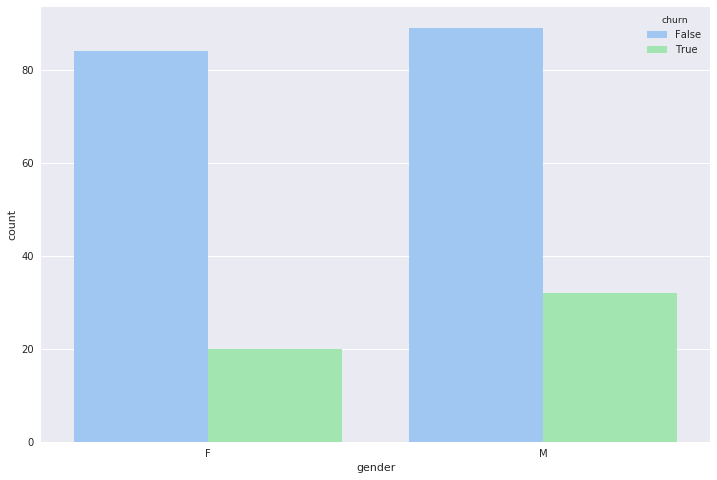

In [33]:
df_genderchurn = userlog_valid.dropDuplicates(["userId", "gender"]).groupby(["gender","churn"]).count().sort("churn").toPandas()

sns.set(rc={'figure.figsize':(12,8)})
sns.set_palette("pastel")
ax=sns.barplot(x='gender', y='count', hue='churn', data=df_genderchurn)

#### 5. itemInSession vs churn

In [34]:
userlog_valid.select("itemInSession").distinct().show()

+-------------+
|itemInSession|
+-------------+
|           26|
|           29|
|          474|
|          964|
|           65|
|          191|
|          418|
|          541|
|          558|
|         1010|
|         1224|
|         1258|
|         1277|
|          222|
|          270|
|          293|
|          730|
|          938|
|         1127|
|         1145|
+-------------+
only showing top 20 rows



In [35]:
# number of iteminSession
df_item=userlog_valid.select("itemInSession").distinct().toPandas()
print(df_item.head())
print(df_item.count())

   itemInSession
0             26
1             29
2            474
3            964
4             65
itemInSession    1311
dtype: int64


#### 6. lastname vs churn

In [36]:
df_lname=userlog_valid.select("lastname").distinct().toPandas()
print(df_lname.head())
print(df_lname.count())

   lastname
0  Harrison
1  Thornton
2      Pena
3     Jones
4    Santos
lastname    173
dtype: int64


#### 7. length vs churn

length    8470
dtype: int64
44864
36394


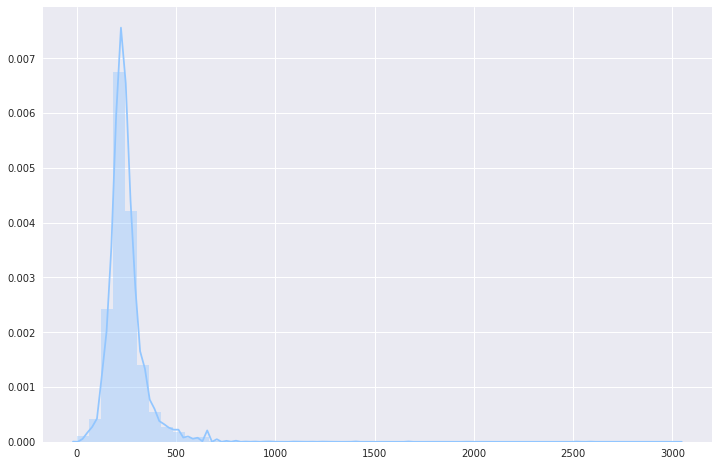

In [37]:
# churn
df_len1=userlog_valid.filter(userlog_valid.churn==1).select('length').toPandas()
print(df_len1.isnull().sum())
print(len(df_len1))
df_len1nonull=df_len1.dropna()
print(len(df_len1nonull))
ax=sns.distplot(df_len1nonull)

length    41576
dtype: int64
233290
191714


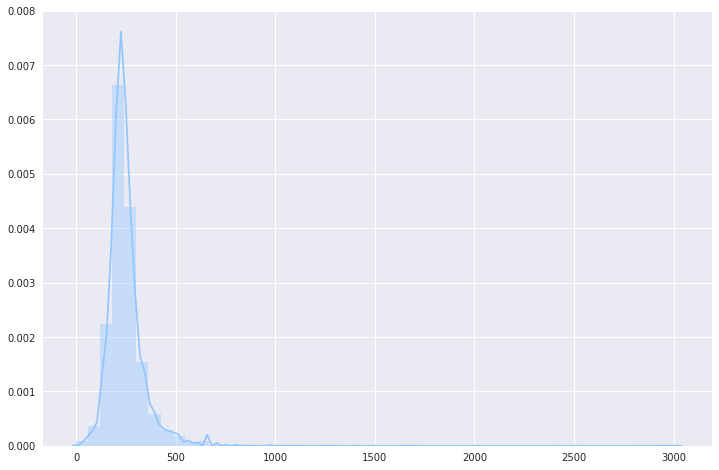

In [38]:
# not churn
df_len0=userlog_valid.filter(userlog_valid.churn==0).select('length').toPandas()
print(df_len0.isnull().sum())
print(len(df_len0))
df_len0nonull=df_len0.dropna()
print(len(df_len0nonull))
ax=sns.distplot(df_len0nonull)

#### 8. level vs churn

In [39]:
userlog_valid.select("level").distinct().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [40]:
userlog_valid.dropDuplicates(["userId", "level"]).groupby(["level","churn"]).count().sort("churn").show()

+-----+-----+-----+
|level|churn|count|
+-----+-----+-----+
| paid|false|  129|
| free|false|  149|
| paid| true|   36|
| free| true|   46|
+-----+-----+-----+



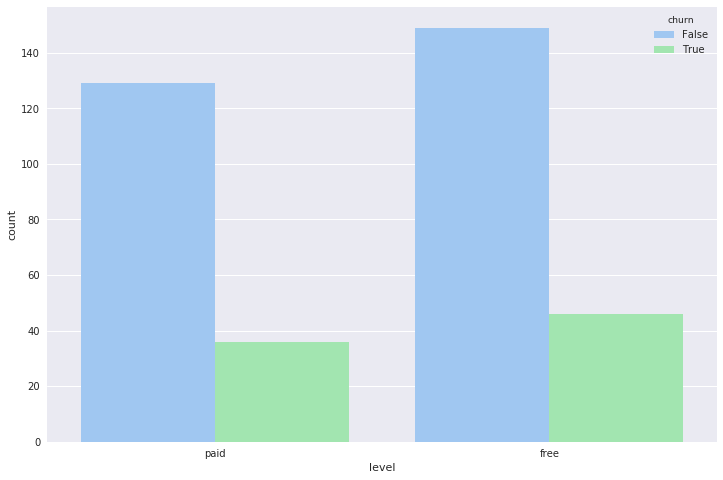

In [41]:
df_levelchurn = userlog_valid.dropDuplicates(["userId", "level"]).groupby(["level","churn"]).count().sort("churn").toPandas()

ax=sns.barplot(x='level', y='count', hue='churn', data=df_levelchurn)

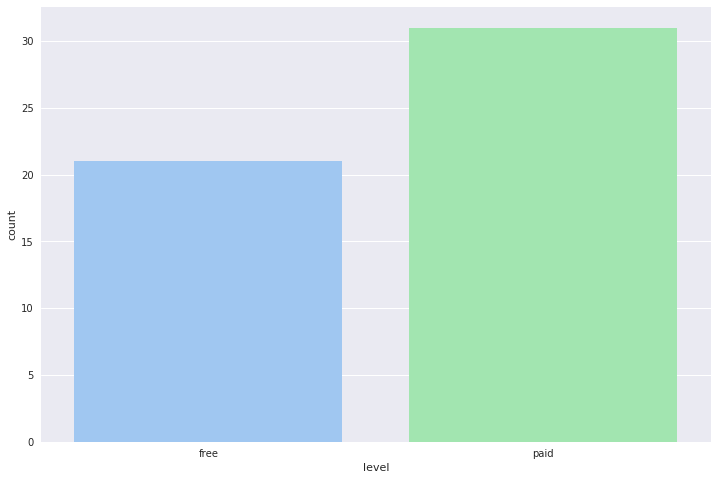

In [42]:
### need to check?
df_pd = userlog_valid.filter(userlog_valid.page=="Cancellation Confirmation").groupby("level").count().toPandas()
sns.barplot(x="level", y="count", data=df_pd)

#### 9. location vs churn

In [43]:
userlog_valid.select("location").distinct().show(n=5)

+--------------------+
|            location|
+--------------------+
|     Gainesville, FL|
|Atlantic City-Ham...|
|Deltona-Daytona B...|
|San Diego-Carlsba...|
|Cleveland-Elyria, OH|
+--------------------+
only showing top 5 rows



In [44]:
df_loc=userlog_valid.select("location").distinct().toPandas()
print(df_loc.head())
print(df_loc.count())

                                 location
0                         Gainesville, FL
1             Atlantic City-Hammonton, NJ
2  Deltona-Daytona Beach-Ormond Beach, FL
3                  San Diego-Carlsbad, CA
4                    Cleveland-Elyria, OH
location    114
dtype: int64


#### 10. method vs churn

In [45]:
userlog_valid.select("method").distinct().show()

+------+
|method|
+------+
|   PUT|
|   GET|
+------+



In [46]:
userlog_valid.dropDuplicates(["userId", "method"]).groupby(["method","churn"]).count().sort("churn").show()

+------+-----+-----+
|method|churn|count|
+------+-----+-----+
|   PUT|false|  173|
|   GET|false|  172|
|   GET| true|   52|
|   PUT| true|   52|
+------+-----+-----+



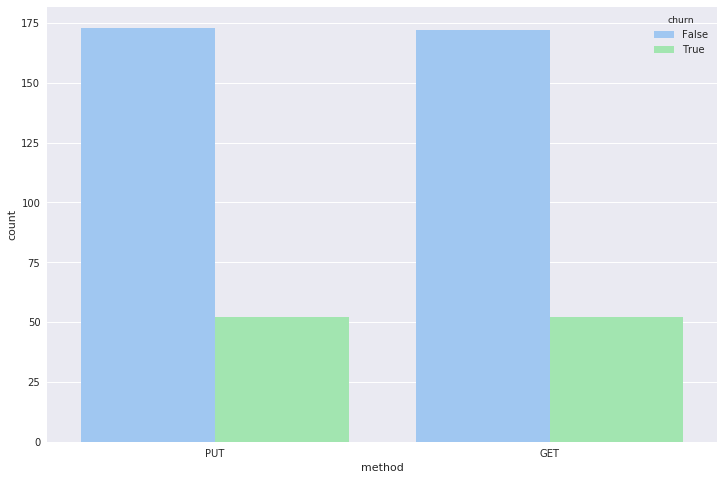

In [47]:
df_methodchurn = userlog_valid.dropDuplicates(["userId", "method"]).groupby(["method","churn"]).count().sort("churn").toPandas()

ax=sns.barplot(x='method', y='count', hue='churn', data=df_methodchurn)

#### 11. page vs churn

In [48]:
userlog_valid.select("page").distinct().show(n=30)

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [49]:
churn_count = userlog_valid.filter(userlog_valid.churn==1).count()
no_churn_count = userlog_valid.filter(userlog_valid.churn==0).count()

df_temp1 = userlog_valid.filter(userlog_valid.churn==1).filter(userlog_valid.page!="NextSong").groupby(["page"]).count()
df_temp1 = df_temp1.withColumn("cFreq", df_temp1["count"]/(churn_count/100)).sort("page")

df_temp2 = userlog_valid.filter(userlog_valid.churn==0).filter(userlog_valid.page!="NextSong").groupby(["page"]).count()
df_temp2 = df_temp2.withColumn("ncFreq", df_temp2["count"]/(no_churn_count/100)).sort("page")

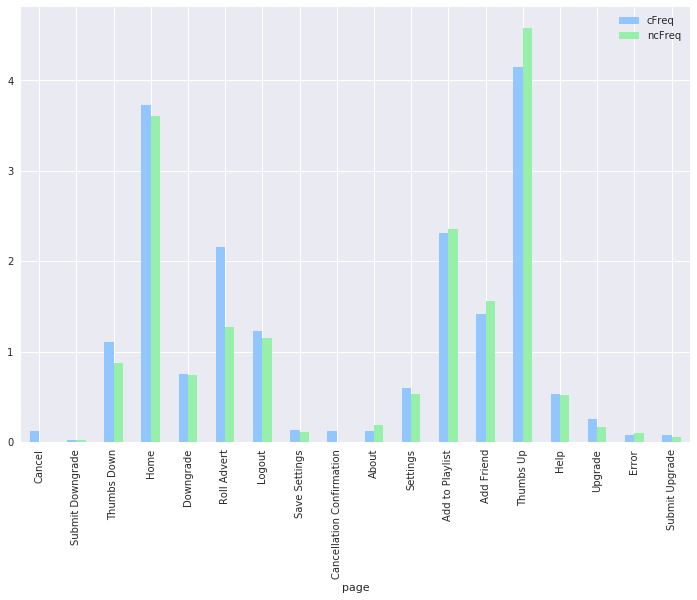

In [50]:
df_page = df_temp1.join(df_temp2, "page", "outer").drop("count").fillna(0).toPandas()
#sns.set_palette("Muted")
df_page.plot.bar("page")

#### fresh up

In [51]:
userlog_valid.show(n=3)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------+--------------------+------+-------------------+-----+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|             song|status|           ts|           userAgent|userId|               time|churn|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------+--------------------+------+-------------------+-----+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|        Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|2018-10-01 00:01:57|false|
|Five Iron Frenzy|Logged In|    Micah|     M

#### 12. regsitration vs churn

registration    0
dtype: int64
44864
44864


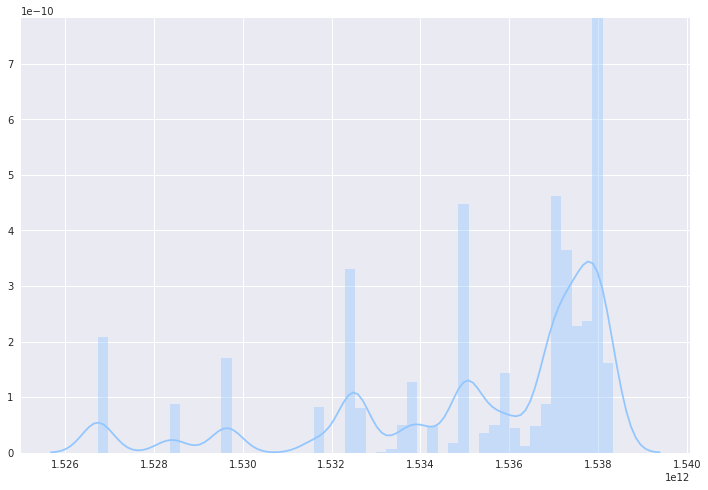

In [52]:
# churn
df_reg1=userlog_valid.filter(userlog_valid.churn==1).select('registration').toPandas()
print(df_reg1.isnull().sum())
print(len(df_reg1))
df_reg1nonull=df_reg1.dropna()
print(len(df_reg1nonull))
ax=sns.distplot(df_reg1nonull)

registration    0
dtype: int64
233290
233290


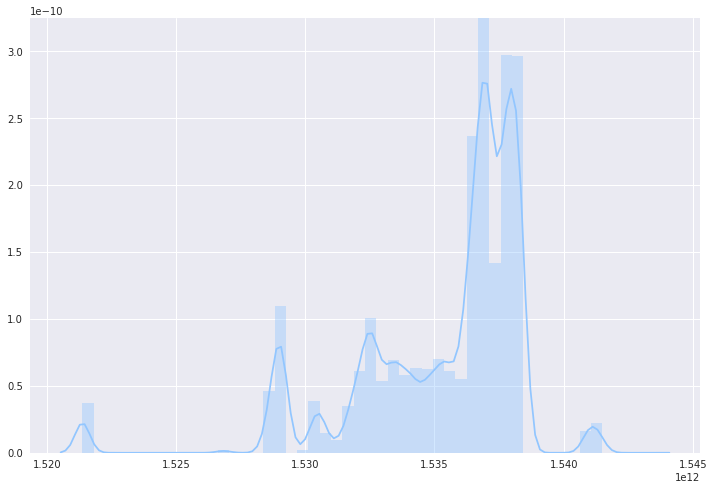

In [53]:
# not churn
df_reg0=userlog_valid.filter(userlog_valid.churn==0).select('registration').toPandas()
print(df_reg0.isnull().sum())
print(len(df_reg0))
df_reg0nonull=df_reg0.dropna()
print(len(df_reg0nonull))
ax=sns.distplot(df_reg0nonull)

#### 13. sessionId vs churn

sessionId    0
dtype: int64
44864
44864


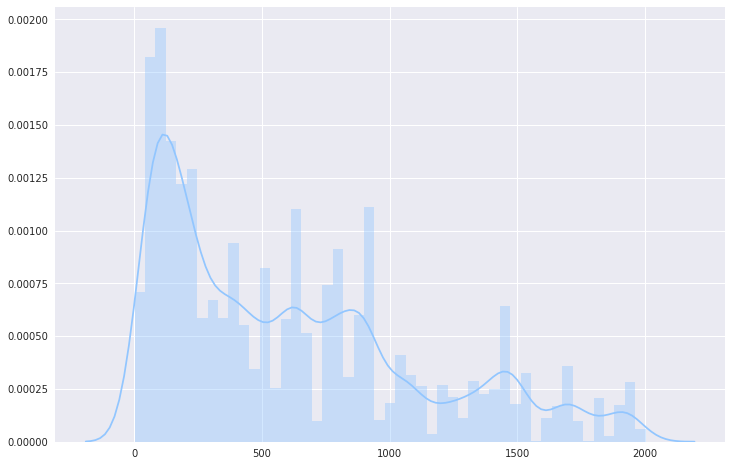

In [54]:
# churn
df_ses1=userlog_valid.filter(userlog_valid.churn==1).select('sessionId').toPandas()
print(df_ses1.isnull().sum())
print(len(df_ses1))
df_ses1nonull=df_ses1.dropna()
print(len(df_ses1nonull))
ax=sns.distplot(df_ses1nonull)

sessionId    0
dtype: int64
233290
233290


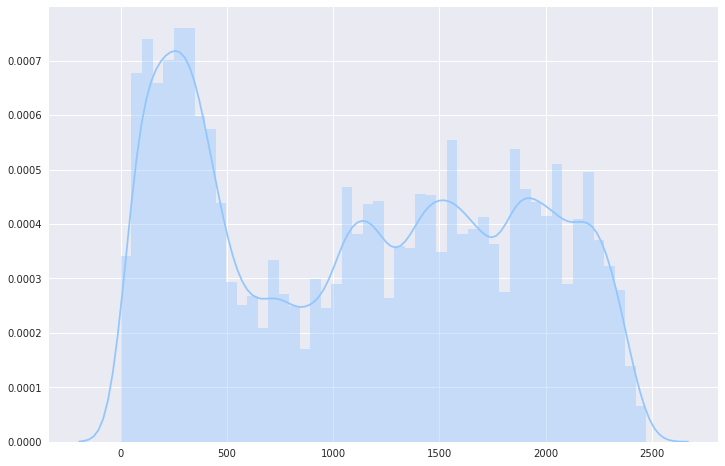

In [55]:
# not churn
df_ses0=userlog_valid.filter(userlog_valid.churn==0).select('sessionId').toPandas()
print(df_ses0.isnull().sum())
print(len(df_ses0))
df_ses0nonull=df_ses0.dropna()
print(len(df_ses0nonull))
ax=sns.distplot(df_ses0nonull)

#### 14. song vs churn

In [56]:
df_song=userlog_valid.select("song").distinct().toPandas()
print(df_song.head())
print(df_song.count())

                                   song
0  Never Gonna Be Alone (Album Version)
1                           TULENLIEKKI
2                        Underwaterboys
3         Saor (Free)/News From Nowhere
4                                 New E
song    58480
dtype: int64


#### 15. status vs churn

In [57]:
userlog_valid.select("status").distinct().show()

+------+
|status|
+------+
|   307|
|   404|
|   200|
+------+



In [58]:
userlog_valid.dropDuplicates(["userId", "status"]).groupby(["status","churn"]).count().sort("churn").show()

+------+-----+-----+
|status|churn|count|
+------+-----+-----+
|   404|false|   95|
|   200|false|  173|
|   307|false|  171|
|   307| true|   52|
|   200| true|   52|
|   404| true|   22|
+------+-----+-----+



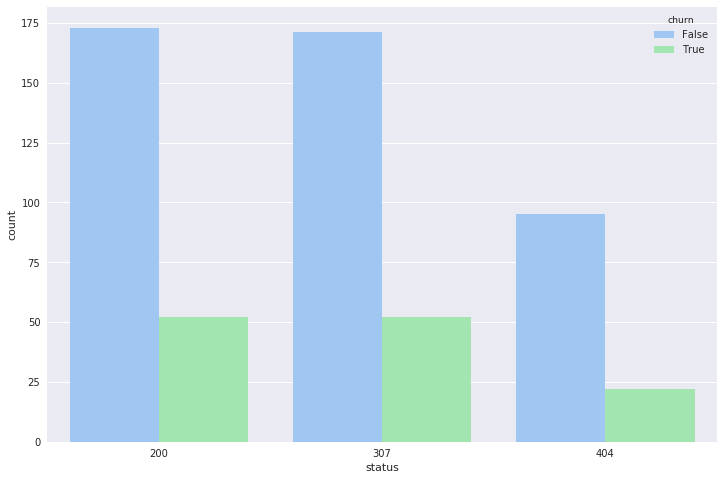

In [59]:
df_statuschurn = userlog_valid.dropDuplicates(["userId", "status"]).groupby(["status","churn"]).count().sort("churn").toPandas()

ax=sns.barplot(x='status', y='count', hue='churn', data=df_statuschurn)

#### 16. ts vs churn

In [61]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
userlog_valid = userlog_valid.withColumn("hour", get_hour(userlog_valid.ts))

get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%w"))
userlog_valid = userlog_valid.withColumn("weekday", get_weekday(userlog_valid.ts))

get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
userlog_valid = userlog_valid.withColumn("day", get_day(userlog_valid.ts))

In [60]:
def plot_cnt_by_churn(time): 
    """
    This function use to plot the distribution of different dimension
    """
    df_pd = userlog_valid.filter(userlog_valid.page == "NextSong").groupby("churn", time).count().orderBy(userlog_valid[time].cast("float")).toPandas()
    df_pd[time] = pd.to_numeric(df_pd[time])
    sns.set_palette("pastel")
    ax=sns.barplot(x=time, y='count', hue='churn', data=df_pd)

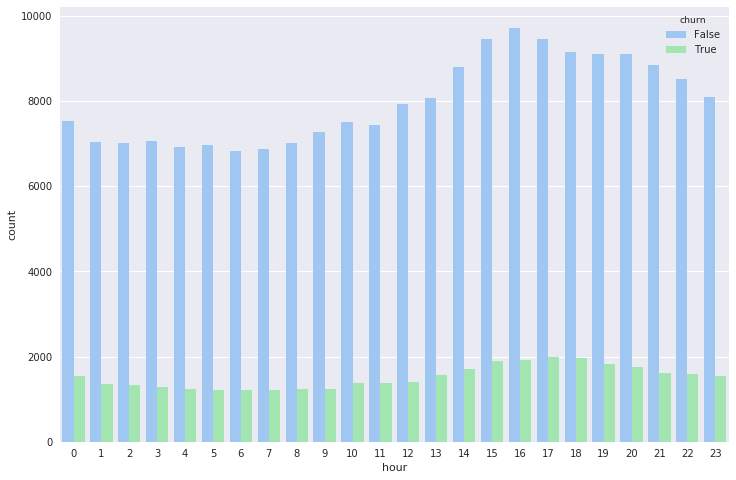

In [62]:
plot_cnt_by_churn("hour")

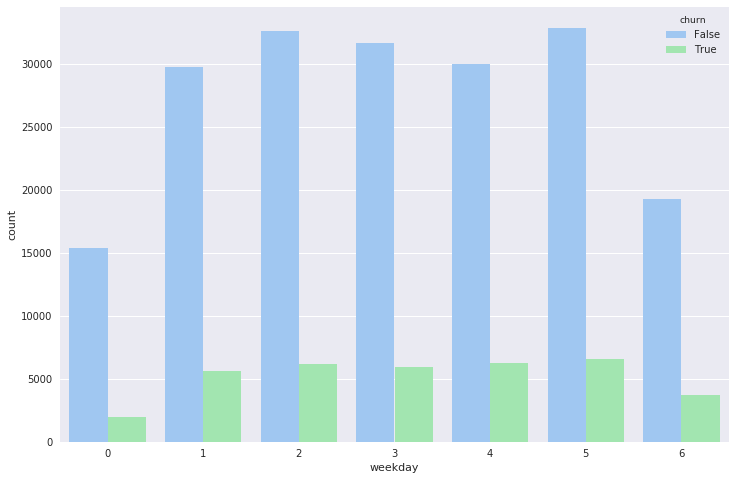

In [63]:
plot_cnt_by_churn("weekday")

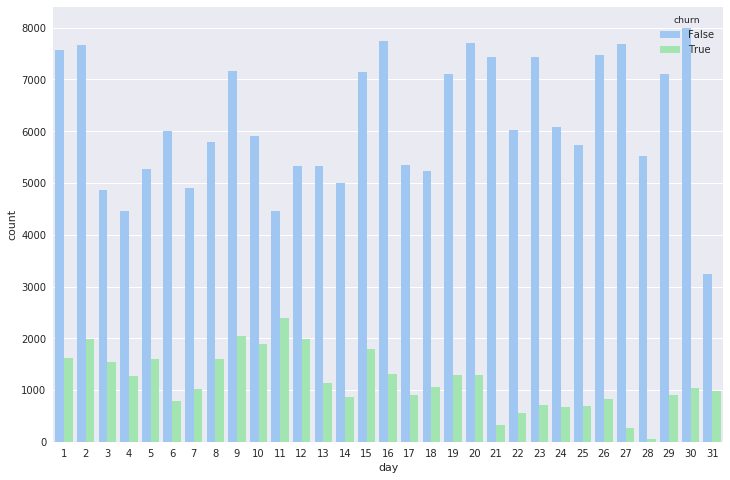

In [64]:
plot_cnt_by_churn("day")

#### 17. userAgent vs churn

In [65]:
userlog_valid.select("userAgent").distinct().show(n=3)

+--------------------+
|           userAgent|
+--------------------+
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Win...|
|Mozilla/5.0 (X11;...|
+--------------------+
only showing top 3 rows



In [66]:
df_uA=userlog_valid.select("userAgent").distinct().toPandas()
print(df_uA.head())
print(df_uA.count())

                                           userAgent
0  "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_5...
1  "Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537....
2  Mozilla/5.0 (X11; Ubuntu; Linux i686; rv:31.0)...
3  "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...
4  "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...
userAgent    56
dtype: int64


#### 18. userId vc churn

In [67]:
df_user=userlog_valid.select("userId").distinct().toPandas()
print(df_user.head())
print(df_user.count())

   userId
0  100010
1  200002
2     125
3      51
4     124
userId    225
dtype: int64


# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [68]:
userlog_valid.show(n=3)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------+--------------------+------+-------------------+-----+----+-------+---+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|             song|status|           ts|           userAgent|userId|               time|churn|hour|weekday|day|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+-----------------+------+-------------+--------------------+------+-------------------+-----+----+-------+---+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|        Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|2018-10-01 00:01:57|

#### Feature 1: number of days since registration

In [69]:
user_max_ts = userlog_valid.groupby("userId").max("ts").sort("userId")
user_reg_ts = userlog_valid.select("userId", "registration").dropDuplicates().sort("userId")
user_reg_days = user_reg_ts.join(user_max_ts, user_reg_ts.userId == user_max_ts.userId).select(user_reg_ts["userId"], ((user_max_ts["max(ts)"]-user_reg_ts["registration"])/(1000*60*60*24)).alias("regDay"))

In [70]:
user_reg_days.show(5)

+------+------------------+
|userId|            regDay|
+------+------------------+
|100010| 55.64365740740741|
|200002| 70.07462962962963|
|   125| 71.31688657407408|
|   124|131.55591435185184|
|    51|19.455844907407407|
+------+------------------+
only showing top 5 rows



#### Feature 2: avg & min & max time per session

In [71]:
user_session_time = userlog_valid.groupby("userId", "sessionId").agg(((max(userlog_valid.ts)-min(userlog_valid.ts))/(1000*60)).alias("sessionTime"))
user_session_time_stat = user_session_time.groupby("userId").agg(avg(user_session_time.sessionTime).alias("avgSessionTime"), min(user_session_time.sessionTime).alias("minSessionTime"), max(user_session_time.sessionTime).alias("maxSessionTime")).sort("userId")

In [72]:
user_session_time_stat.show(5)

+------+------------------+-----------------+------------------+
|userId|    avgSessionTime|   minSessionTime|    maxSessionTime|
+------+------------------+-----------------+------------------+
|    10|459.74722222222226|91.41666666666667|1547.9166666666667|
|   100| 316.5190476190476|              0.0|1019.5833333333334|
|100001|148.15833333333333|             63.0|215.28333333333333|
|100002|201.18333333333334|              0.0| 730.4666666666667|
|100003| 99.11666666666667|3.216666666666667|195.01666666666668|
+------+------------------+-----------------+------------------+
only showing top 5 rows



#### Feature 3: number of songs per session

In [73]:
user_session_songs = userlog_valid.filter(userlog_valid.page=="NextSong").groupby("userId", "sessionId").count()
user_session_songs_avg = user_session_songs.groupby("userId").agg(avg(user_session_songs["count"]).alias("avgSessionSongs")).sort("userId")

In [74]:
user_session_songs_avg.show(5)

+------+------------------+
|userId|   avgSessionSongs|
+------+------------------+
|    10|112.16666666666667|
|   100| 78.88235294117646|
|100001|             33.25|
|100002|             48.75|
|100003|              25.5|
+------+------------------+
only showing top 5 rows



#### Feature 4: number of sessions

In [75]:
user_session_count = userlog_valid.select("userId", "sessionId").dropDuplicates().groupby("userId").count()
user_session_count = user_session_count.withColumnRenamed("count", "sessionCount")

In [76]:
user_session_count.show(5)

+------+------------+
|userId|sessionCount|
+------+------------+
|100010|           7|
|200002|           6|
|   125|           1|
|    51|          10|
|   124|          29|
+------+------------+
only showing top 5 rows



#### Feature 5: gender

In [77]:
user_gender = userlog_valid.select("userId", "gender").dropDuplicates()
user_gender = user_gender.replace(["M", "F"], ["0", "1"], "gender")
user_gender = user_gender.select("userId", user_gender.gender.cast("int"))

In [78]:
user_gender.show(5)

+------+------+
|userId|gender|
+------+------+
|    44|     1|
|    46|     1|
|    41|     1|
|    72|     1|
|300023|     1|
+------+------+
only showing top 5 rows



#### Feature 6: whether the user is currently a paid user

In [79]:
user_paid = userlog_valid.groupby("userId", "level").agg(max(userlog_valid.ts).alias("finalTime")).sort("userId")
user_recent_level_time = user_paid.groupby("userId").agg(max(user_paid.finalTime).alias("recent"))
user_recent_level = user_recent_level_time.join(user_paid, [user_paid.userId == user_recent_level_time.userId, user_recent_level_time.recent == user_paid.finalTime]).select(user_paid.userId, "level").sort("userId")
user_recent_level = user_recent_level.replace(["free", "paid"], ["0", "1"], "level")
user_recent_level = user_recent_level.select("userId", user_recent_level.level.cast("int"))

In [80]:
user_recent_level.show(5)

+------+-----+
|userId|level|
+------+-----+
|    10|    1|
|   100|    1|
|100001|    0|
|100002|    1|
|100003|    0|
+------+-----+
only showing top 5 rows



#### Feature 7: frequency of use of pages

In [82]:
# get all the type of page
page_list = [(row['page']) for row in userlog_valid.select("page").dropDuplicates().collect()]

# must remove the column which will cause data leakage
page_list.remove("Cancel")
page_list.remove("Cancellation Confirmation")

# caculate the total page each user view
user_page_view_count = userlog_valid.groupby("userId").count()
user_page_view_count = user_page_view_count.withColumnRenamed("count", "pageCount")


for page in page_list:
    col_name = "count" + page.replace(" ", "")
    view_count = userlog_valid.filter(userlog_valid.page==page).groupby("userId").count()
    view_count = view_count.withColumnRenamed("count", col_name).withColumnRenamed("userId", "userIdTemp")
    user_page_view_count = user_page_view_count.join(view_count, user_page_view_count.userId==view_count.userIdTemp, "left").drop("userIdTemp")
user_page_view_count = user_page_view_count.sort("userId")
user_page_view_count = user_page_view_count.fillna(0)

In [83]:
col_list = user_page_view_count.columns
col_list.remove("userId")
col_list.remove("pageCount")
freq_sql = "select userId"
for col in col_list:
    col_name = col.replace("count", "freq")
    sql_str = ", (" + col + "/(pageCount/100)) as " + col_name
    freq_sql = freq_sql + sql_str
freq_sql = freq_sql + " from user_page_view_count"

user_page_view_count.createOrReplaceTempView("user_page_view_count")
col_list = user_page_view_count.columns
col_list.remove("userId")
col_list.remove("pageCount")
freq_sql = "select userId"
for col in col_list:
    col_name = col.replace("count", "freq")
    sql_str = ", (" + col + "/(pageCount/100)) as " + col_name
    freq_sql = freq_sql + sql_str
freq_sql = freq_sql + " from user_page_view_count"

user_page_view_freq = spark.sql(freq_sql)

In [84]:
user_page_view_freq.show(5)

+------+--------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-----------------+-----------------+-------------------+--------------------+-------------------+--------------------+
|userId| freqSubmitDowngrade|    freqThumbsDown|          freqHome|     freqDowngrade|     freqRollAdvert|        freqLogout|   freqSaveSettings|          freqAbout|       freqSettings| freqAddtoPlaylist|     freqAddFriend|     freqNextSong|     freqThumbsUp|           freqHelp|         freqUpgrade|          freqError|   freqSubmitUpgrade|
+------+--------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-----------------+-----------------+-------------------+--------------------+----------------

#### Feature 8: how many singers have the user heard

In [85]:
user_artist_count = userlog_valid.filter(userlog_valid.page=="NextSong").select("userId", "artist").dropDuplicates().groupby("userId").count()
user_artist_count = user_artist_count.withColumnRenamed("count", "aritstCount")

In [86]:
user_artist_count.show(5)

+------+-----------+
|userId|aritstCount|
+------+-----------+
|100010|        252|
|200002|        339|
|   125|          8|
|    51|       1385|
|   124|       2232|
+------+-----------+
only showing top 5 rows



#### Out target label: churn

In [87]:
user_churn = userlog_valid.select("userId", "churn").dropDuplicates()
user_churn = user_churn.select("userId", user_churn.churn.cast("int"))

In [88]:
user_churn.show(5)

+------+-----+
|userId|churn|
+------+-----+
|    19|    0|
|100005|    1|
|200007|    0|
|300007|    1|
|    50|    0|
+------+-----+
only showing top 5 rows



Put all the features into a dataframe

In [89]:
# put all the features dataframe into a list
features_list = []
features_list.append(user_reg_days)
features_list.append(user_session_time_stat)
features_list.append(user_session_songs_avg)
features_list.append(user_session_count)
features_list.append(user_gender)
features_list.append(user_recent_level)
features_list.append(user_page_view_freq)
features_list.append(user_artist_count)
features_list.append(user_churn)

In [93]:
# prepare the final dataframe to join all the other features
df_final = userlog_valid.select("userId").dropDuplicates()

In [94]:
def features_merge(df1, df2):
    """
    This function is used to merge the feature using left join
    input: two data frame to be merged
    output: merged dataframe
    """
    df2 = df2.withColumnRenamed("userId", "userIdTemp")
    df = df1.join(df2, df1.userId == df2.userIdTemp, "left").drop("userIdTemp")
    return df

In [95]:
# use function to merge the features in the list
for feature in features_list:
    df_final = features_merge(df_final, feature)

In [96]:
# sort and view the final dataframe
df_final = df_final.sort("userId")
df_final.persist()
df_final.show(5)

+------+------------------+------------------+-----------------+------------------+------------------+------------+------+-----+--------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+-----------------+-----------------+-------------------+--------------------+-------------------+--------------------+-----------+-----+
|userId|            regDay|    avgSessionTime|   minSessionTime|    maxSessionTime|   avgSessionSongs|sessionCount|gender|level| freqSubmitDowngrade|    freqThumbsDown|          freqHome|     freqDowngrade|     freqRollAdvert|        freqLogout|   freqSaveSettings|          freqAbout|       freqSettings| freqAddtoPlaylist|     freqAddFriend|     freqNextSong|     freqThumbsUp|           freqHelp|         freqUpgrade|          freqError|   freqSubmitUpgrade|aritstCount|churn|
+------+------------------+-------------

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

See how many data do we have.

In [97]:
df_final.groupby("churn").count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    1|   52|
|    0|  173|
+-----+-----+



In [98]:
out_path = "final_data.csv"

In [99]:
df_final.write.save(out_path, format="csv", header=True)

In [100]:
df_final = spark.read.csv(out_path, header=True)
df_final.persist()

DataFrame[userId: string, regDay: string, avgSessionTime: string, minSessionTime: string, maxSessionTime: string, avgSessionSongs: string, sessionCount: string, gender: string, level: string, freqSubmitDowngrade: string, freqThumbsDown: string, freqHome: string, freqDowngrade: string, freqRollAdvert: string, freqLogout: string, freqSaveSettings: string, freqAbout: string, freqSettings: string, freqAddtoPlaylist: string, freqAddFriend: string, freqNextSong: string, freqThumbsUp: string, freqHelp: string, freqUpgrade: string, freqError: string, freqSubmitUpgrade: string, aritstCount: string, churn: string]

#### Convert all the features to numeric.

In [102]:
num_features_list = df_final.columns[1:]
for f in num_features_list:
    f_name = f + "Num"
    df_final = df_final.withColumn(f_name, df_final[f].cast("float"))
    df_final = df_final.drop(f)

In [103]:
df_final.head()

Row(userId='30', regDayNum=63.06664276123047, avgSessionTimeNum=183.59426879882812, minSessionTimeNum=0.0, maxSessionTimeNum=1089.0333251953125, avgSessionSongsNum=50.60714340209961, sessionCountNum=32.0, genderNum=0.0, levelNum=1.0, freqSubmitDowngradeNum=0.056338027119636536, freqThumbsDownNum=0.9577465057373047, freqHomeNum=3.94366192817688, freqDowngradeNum=0.3380281627178192, freqRollAdvertNum=4.056337833404541, freqLogoutNum=1.1267606019973755, freqSaveSettingsNum=0.056338027119636536, freqAboutNum=0.1690140813589096, freqSettingsNum=0.7323943376541138, freqAddtoPlaylistNum=2.6478872299194336, freqAddFriendNum=1.408450722694397, freqNextSongNum=79.83098602294922, freqThumbsUpNum=3.492957830429077, freqHelpNum=0.28169015049934387, freqUpgradeNum=0.7887324094772339, freqErrorNum=0.056338027119636536, freqSubmitUpgradeNum=0.056338027119636536, aritstCountNum=1018.0, churnNum=0.0)

#### Put the features to be trained into a vector

In [104]:
assembler = VectorAssembler(inputCols=df_final.columns[1:-1], outputCol="NumFeatures")
data = assembler.transform(df_final)

In [105]:
scaler = StandardScaler(inputCol="NumFeatures", outputCol="ScaledNumFeatures", withStd=True)
scalerModel = scaler.fit(data)
data = scalerModel.transform(data)

In [106]:
data = data.select(data.churnNum.alias("label"), data.ScaledNumFeatures.alias("features"))

In [122]:
train, test = data.randomSplit([0.9, 0.1], seed=42)
train = train.cache()

In [150]:
def model_fit(train, test, model):
    '''
    INPUTS:
    train (Spark df): training data
    test (Spark df): testing data
    model (string): 'LogisticRegression', 'DecisionTree', 'RandomForest', 'GradientBoosting'
    
    OUTPUT:
    None, prints out accuracy and f1 score for the model
    
    '''

    if model == 'LogisticRegression':
        ml = LogisticRegression()
        
    elif model == 'DecisionTree':
        ml = DecisionTreeClassifier()
        
    elif model == 'RandomForest':
        ml = RandomForestClassifier()
        
    elif model == 'GradientBoosting':
        ml = GBTClassifier()
        
    else:
        return "Please choose an appropriate model"
    

    classification = ml.fit(train)
    results = classification.transform(test)
    

    accuracy_evaluator = MulticlassClassificationEvaluator(metricName='accuracy')
    accuracy = accuracy_evaluator.evaluate(results.select('label', 'prediction'))
    
    f1_score_evaluator = MulticlassClassificationEvaluator(metricName='f1')
    f1_score = f1_score_evaluator.evaluate(results.select('label', 'prediction'))
    
    print('For {}, the accuracy is {:.2%} and the F-1 score is {}'\
    .format(model, accuracy, f1_score))
    

In [153]:
def model_fitCV(train, test, model):
    '''
    INPUTS:
    train (Spark df): training data
    test (Spark df): testing data
    model (string): 'LogisticRegression', 'DecisionTree', 'RandomForest', 'GradientBoosting'
    
    OUTPUT:
    None, prints out accuracy and f1 score for the model
    
    '''

    if model == 'LogisticRegression':
        ml = LogisticRegression()
        
        paramGrid = ParamGridBuilder() \
            .addGrid(ml.elasticNetParam,[0.0, 0.1, 0.5, 1.0]) \
            .addGrid(ml.regParam,[0.0, 0.05, 0.1]) \
            .build()
        
        crossval = CrossValidator(estimator=ml,
                                  estimatorParamMaps=paramGrid,
                                  evaluator=MulticlassClassificationEvaluator(),
                                  numFolds=3)
        
    elif model == 'DecisionTree':
        ml = DecisionTreeClassifier()
        
        paramGrid = ParamGridBuilder() \
            .addGrid(ml.impurity,['entropy', 'gini']) \
            .addGrid(ml.maxDepth,[2, 3, 4, 5, 6, 7, 8]) \
            .build()

        crossval = CrossValidator(estimator=ml,
                                  estimatorParamMaps=paramGrid,
                                  evaluator=MulticlassClassificationEvaluator(),
                                  numFolds=3)
        
    elif model == 'RandomForest':
        ml = RandomForestClassifier()
        
        param_grid = ParamGridBuilder() \
            .addGrid(ml.minInfoGain, [0, 1]) \
            .addGrid(ml.numTrees, [20, 50]) \
            .addGrid(ml.maxDepth, [5, 10]) \
            .build()
        
        crossval = CrossValidator(estimator = ml,
                                  estimatorParamMaps = param_grid,
                                  evaluator = MulticlassClassificationEvaluator(),
                                  numFolds = 3)
        
    elif model == 'GradientBoosting':
        ml = GBTClassifier()
        
        paramGrid = ParamGridBuilder() \
            .addGrid(ml.maxIter,[3, 10, 20]) \
            .addGrid(ml.maxDepth,[2, 4, 6, 8]) \
            .build()

        crossval = CrossValidator(estimator=ml,
                                      estimatorParamMaps=paramGrid,
                                      evaluator=MulticlassClassificationEvaluator(),
                                      numFolds=3)
        
    else:
        return "Please choose an appropriate model"  
    
    #########
    
    print('The following is Grid search for the model {}'.format(model))
    
    classificationCV = crossval.fit(train)
    resultsCV = classificationCV.transform(test)
    
    accuracyCV = accuracy_evaluator.evaluate(resultsCV.select('label', 'prediction'))
    f1_scoreCV = f1_score_evaluator.evaluate(resultsCV.select('label', 'prediction'))
    
    print('For {} in Grid Search, the accuracy is {:.2%} and the F-1 score is {}'\
    .format(model, accuracyCV, f1_scoreCV))
    
    # Feature importance
    #DenseVector(classificationCV.bestModel.stages[-1].featureImportances)

In [154]:
for model in ['LogisticRegression', 'DecisionTree', 'RandomForest', 'GradientBoosting']:
    model_fit(train, test, model)
    model_fitCV(train, test, model)

For LogisticRegression, the accuracy is 66.67% and the F-1 score is 0.6526610644257702
The following is Grid search for the model LogisticRegression
For LogisticRegression in Grid Search, the accuracy is 66.67% and the F-1 score is 0.6526610644257702
For DecisionTree, the accuracy is 62.50% and the F-1 score is 0.5978021978021979
The following is Grid search for the model DecisionTree
For DecisionTree in Grid Search, the accuracy is 75.00% and the F-1 score is 0.7394957983193278
For RandomForest, the accuracy is 75.00% and the F-1 score is 0.7222222222222222
The following is Grid search for the model RandomForest
For RandomForest in Grid Search, the accuracy is 75.00% and the F-1 score is 0.7222222222222222
For GradientBoosting, the accuracy is 70.83% and the F-1 score is 0.7030303030303031
The following is Grid search for the model GradientBoosting
For GradientBoosting in Grid Search, the accuracy is 70.83% and the F-1 score is 0.7030303030303031


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.